## Resources

- https://rtdew1.github.io/#research
- https://deliverypdf.ssrn.com/delivery.php?ID=437004004092116102112081007115085100113004071015039058088007022119000115065101121025101010116127126036124022103112072006028021016015022093033075007022030093123074027005089055101008125010121127088121118024120014080084103086015111116116068127029104027086&EXT=pdf&INDEX=TRUE
- https://rtdew1.github.io/gppm_replication_notebook.html
- https://github.com/rtdew1/rtdew1.github.io/blob/master/gppm.stan

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns

# auxiliary functions taken from https://num.pyro.ai/en/stable/examples/hsgp.html
from hsgp import approx_periodic_gp_ncp, approx_se_ncp
from jax import random
from jax.scipy.special import expit
from numpyro.handlers import scope
from numpyro.infer import MCMC, NUTS, Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

In [2]:
data_df = pl.read_csv(
    "https://raw.githubusercontent.com/rtdew1/rtdew1.github.io/master/ls_sim.csv"
)
data_df = data_df.filter(pl.col("id") < 50)
data_df.head()

y,id,fs,t,r,l,pnum
i64,i64,i64,i64,i64,i64,i64
0,1,20,21,1,1,2
0,1,20,22,2,2,2
0,1,20,23,3,3,2
0,1,20,24,4,4,2
0,1,20,25,5,5,2


## EDA

In [3]:
data_df["id"].unique().shape[0]

49

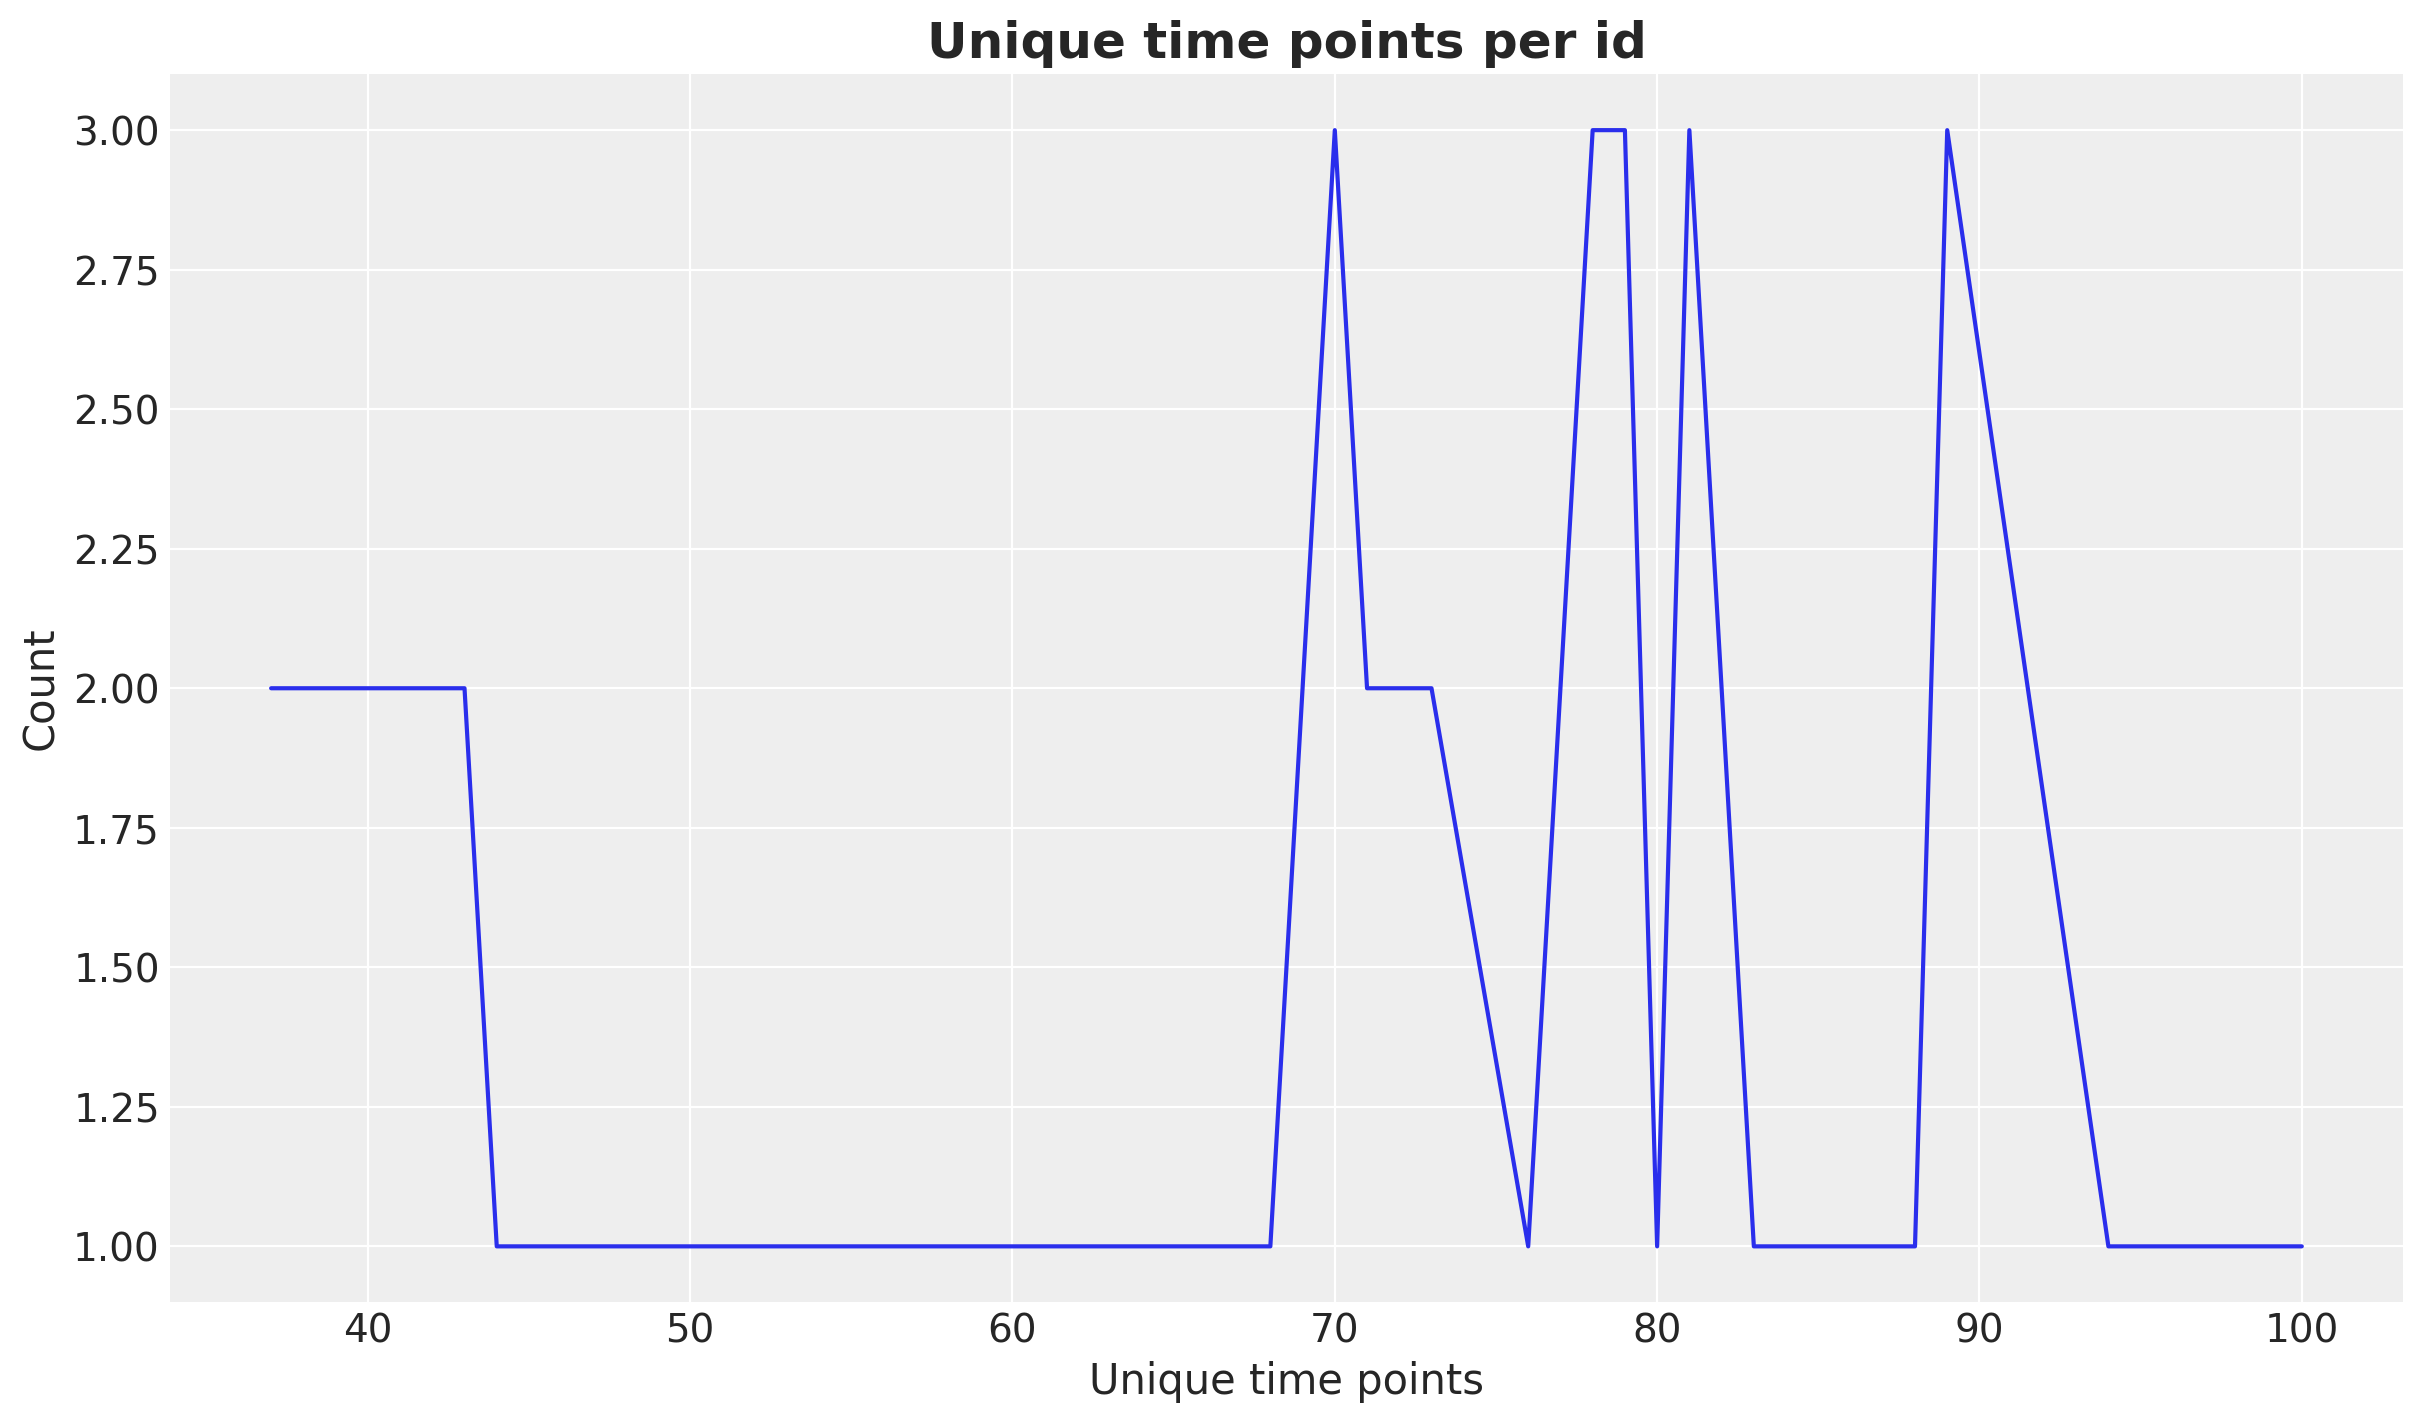

In [4]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("t").count().alias("t_unique"))
    .sort("t_unique")
    .group_by("t_unique")
    .agg(pl.col("id").count().alias("count"))
    .pipe(lambda df: sns.lineplot(data=df, x="t_unique", y="count", ax=ax))
)
ax.set(xlabel="Unique time points", ylabel="Count")
ax.set_title("Unique time points per id", fontsize=18, fontweight="bold");

In [5]:
(
    data_df.group_by("id")
    .agg(pl.col("t").max().alias("max_t"))
    .select(pl.col("max_t").unique().alias("max_t_unique"))
)

max_t_unique
i64
100


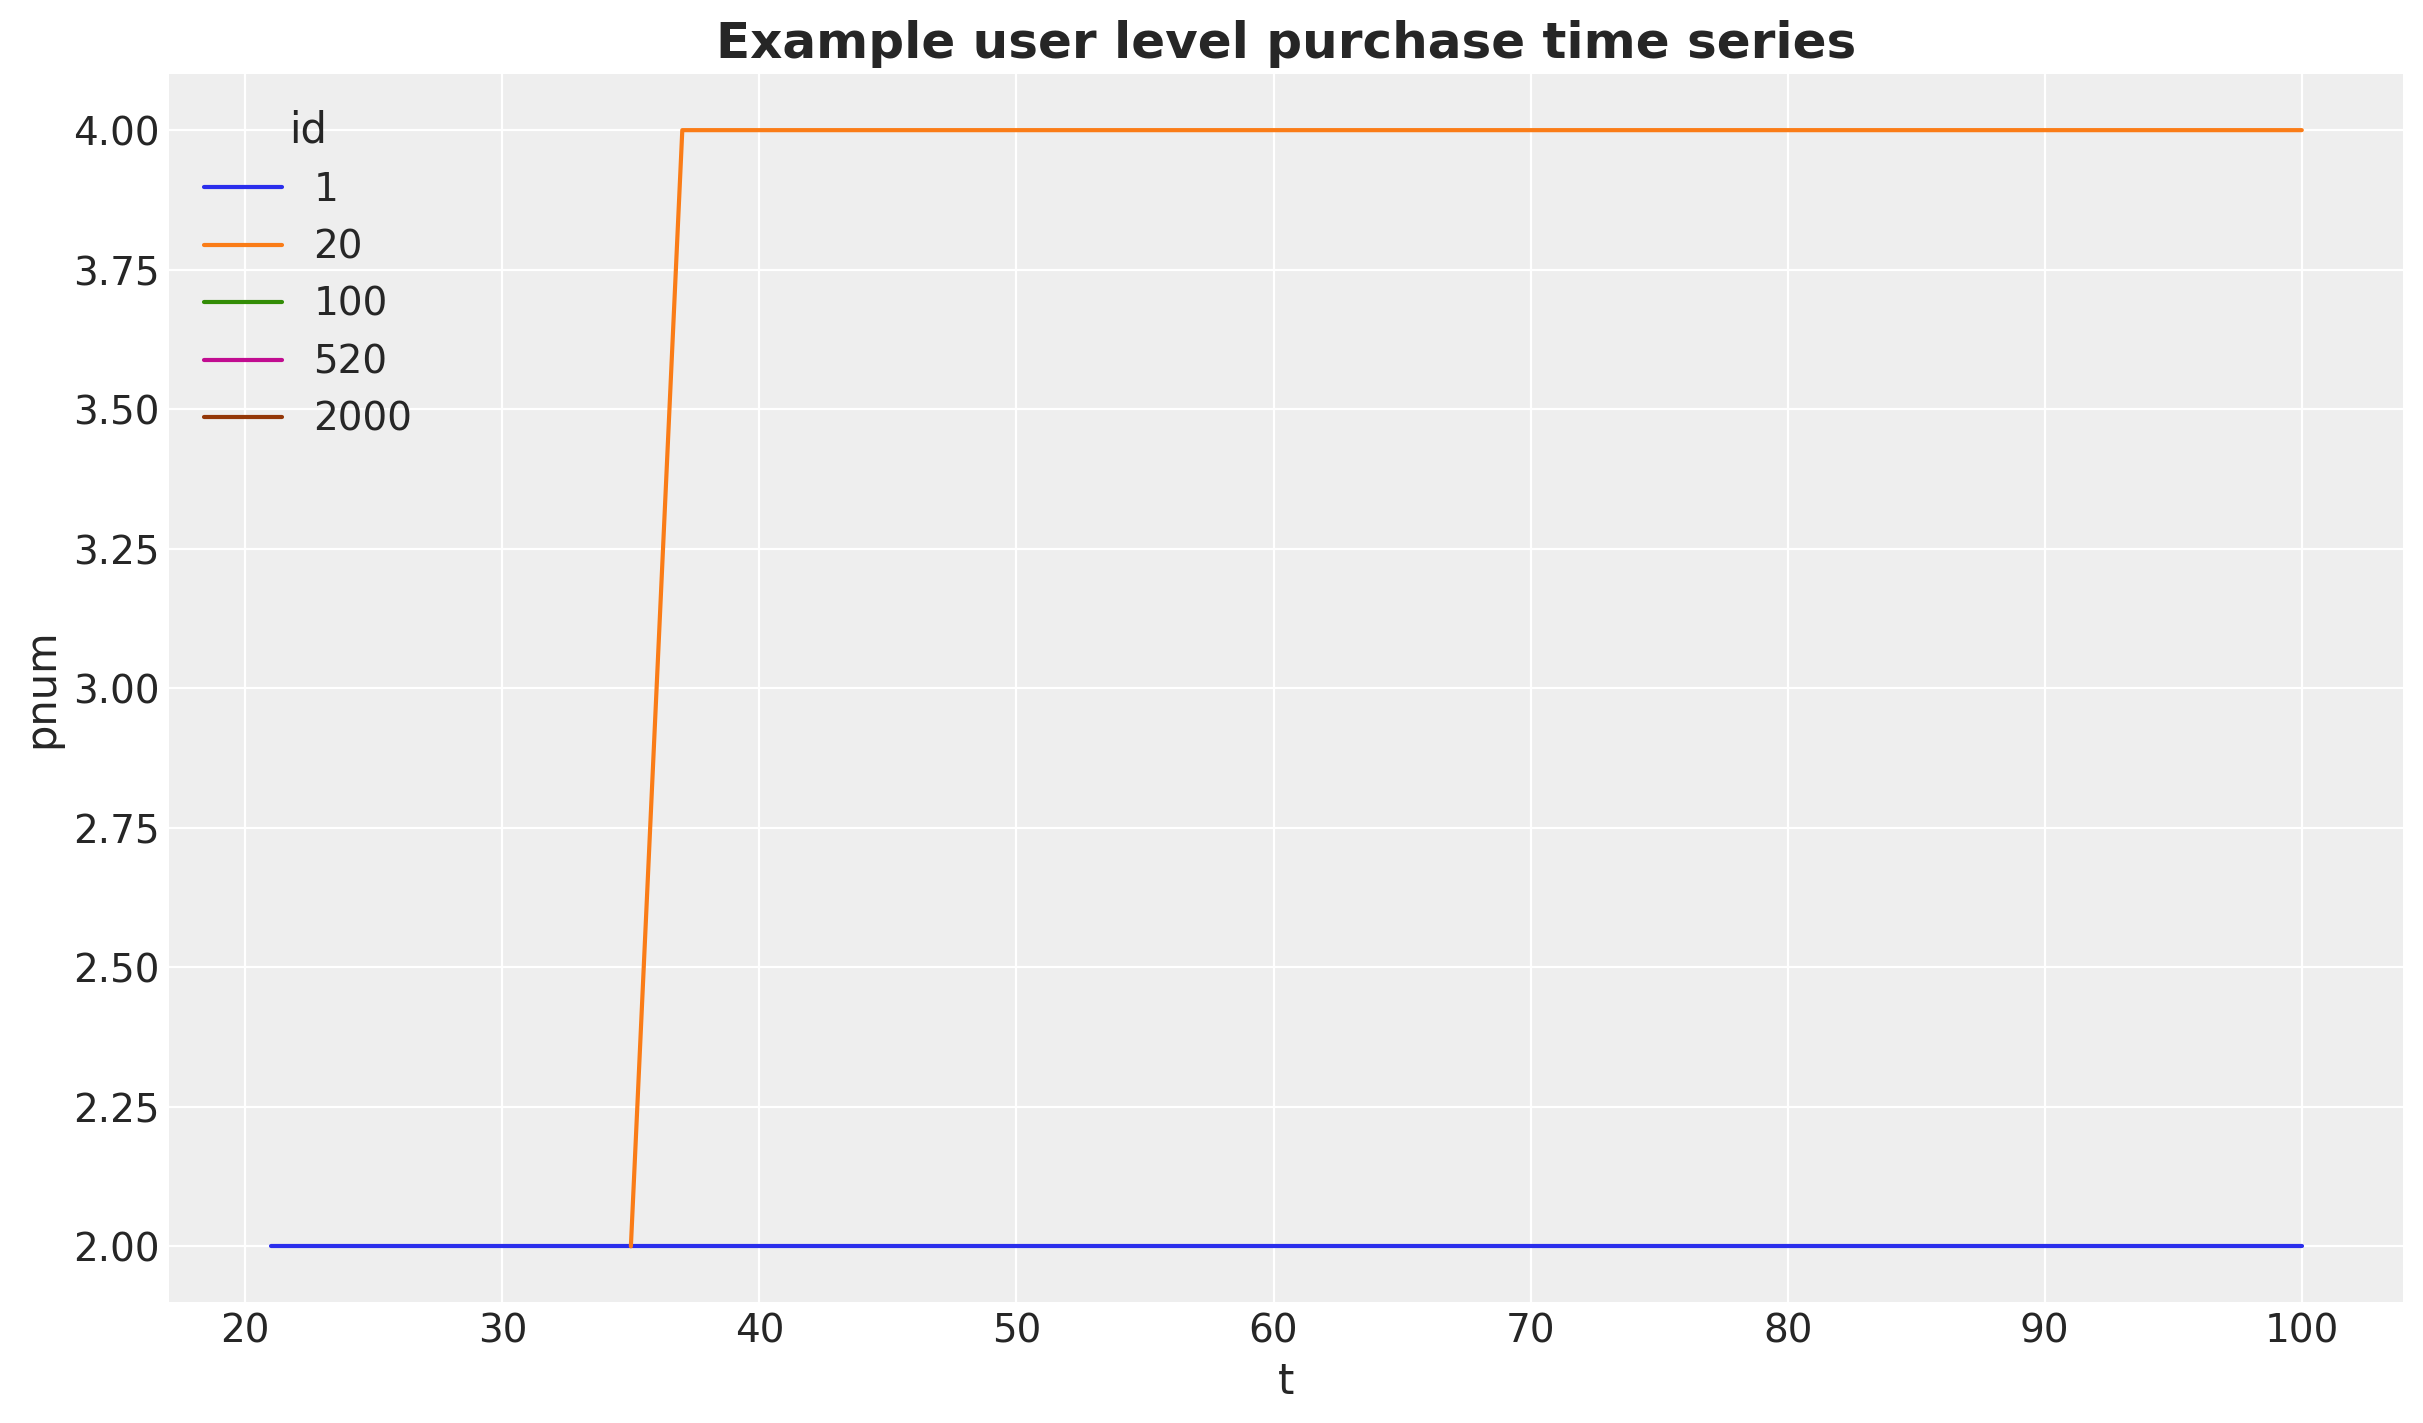

In [6]:
fig, ax = plt.subplots()
for i, idx in enumerate([1, 20, 100, 520, 2000]):
    sns.lineplot(
        data=data_df.filter(pl.col("id") == idx),
        x="t",
        y="pnum",
        color=f"C{i}",
        label=idx,
        ax=ax,
    )
ax.legend(title="id", title_fontsize=15, loc="upper left")
ax.set_title("Example user level purchase time series", fontsize=18, fontweight="bold");

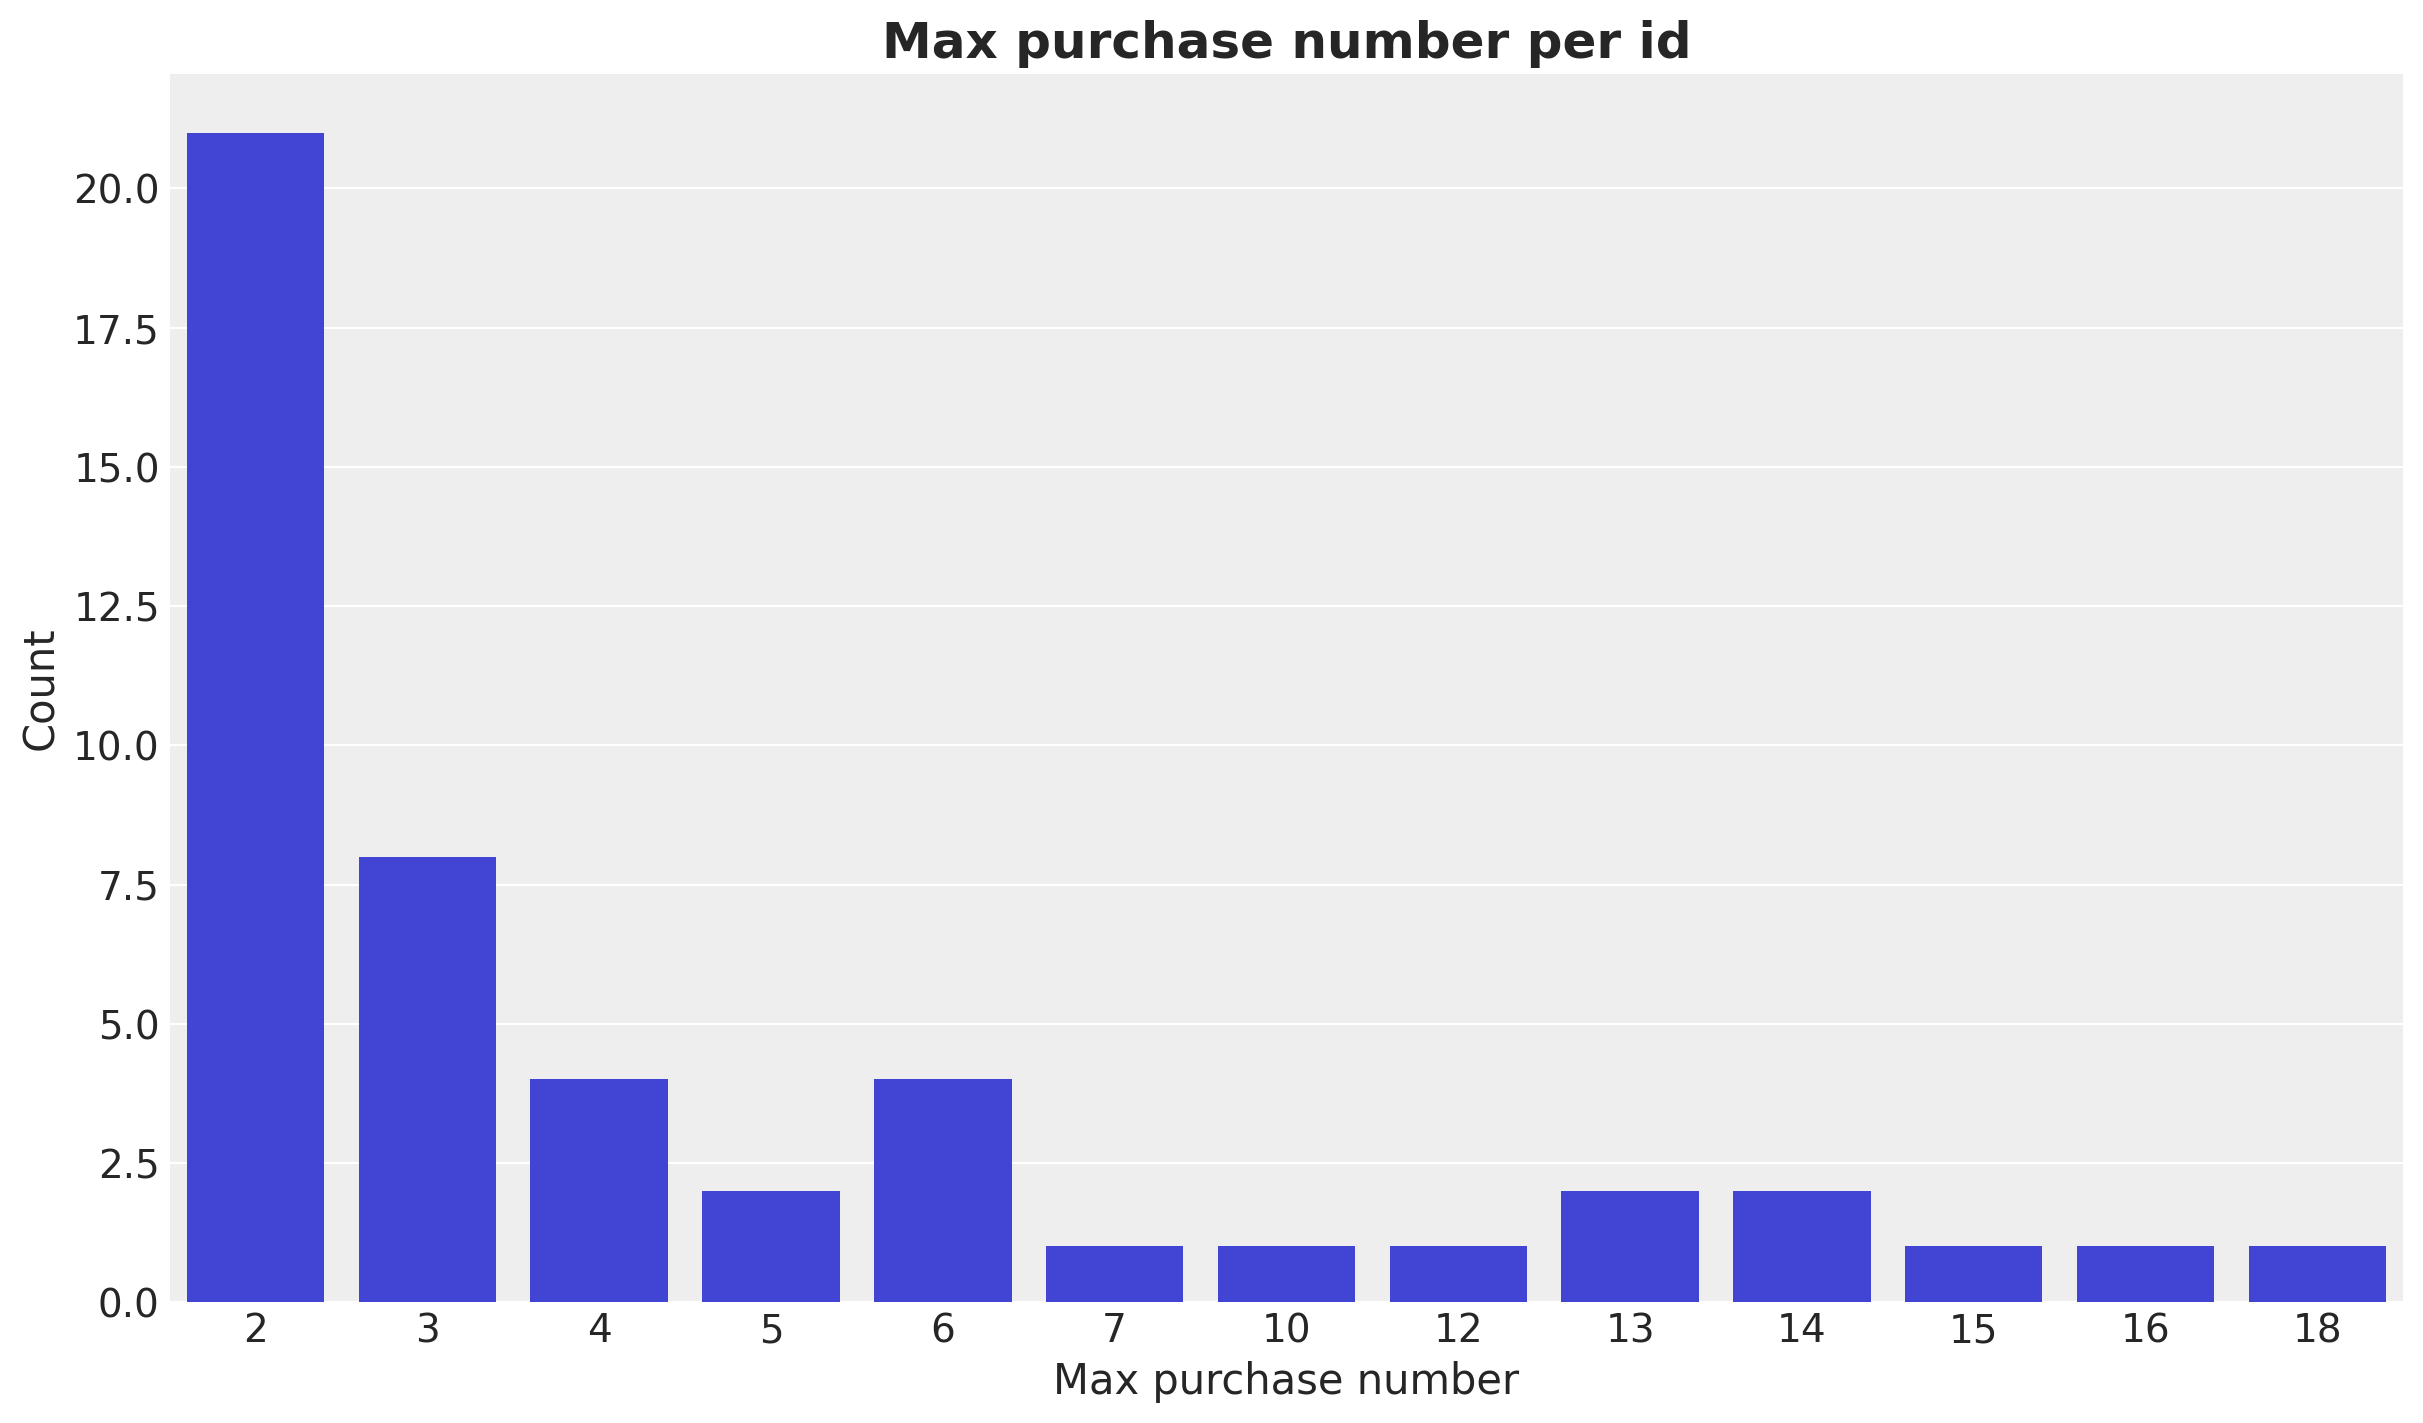

In [7]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("pnum").max().alias("max_pnum"))
    .group_by("max_pnum")
    .agg(pl.col("id").count().alias("count"))
    .sort("count")
    .pipe(lambda df: sns.barplot(data=df, x="max_pnum", y="count"))
)
ax.set(xlabel="Max purchase number", ylabel="Count")
ax.set_title("Max purchase number per id", fontsize=18, fontweight="bold");

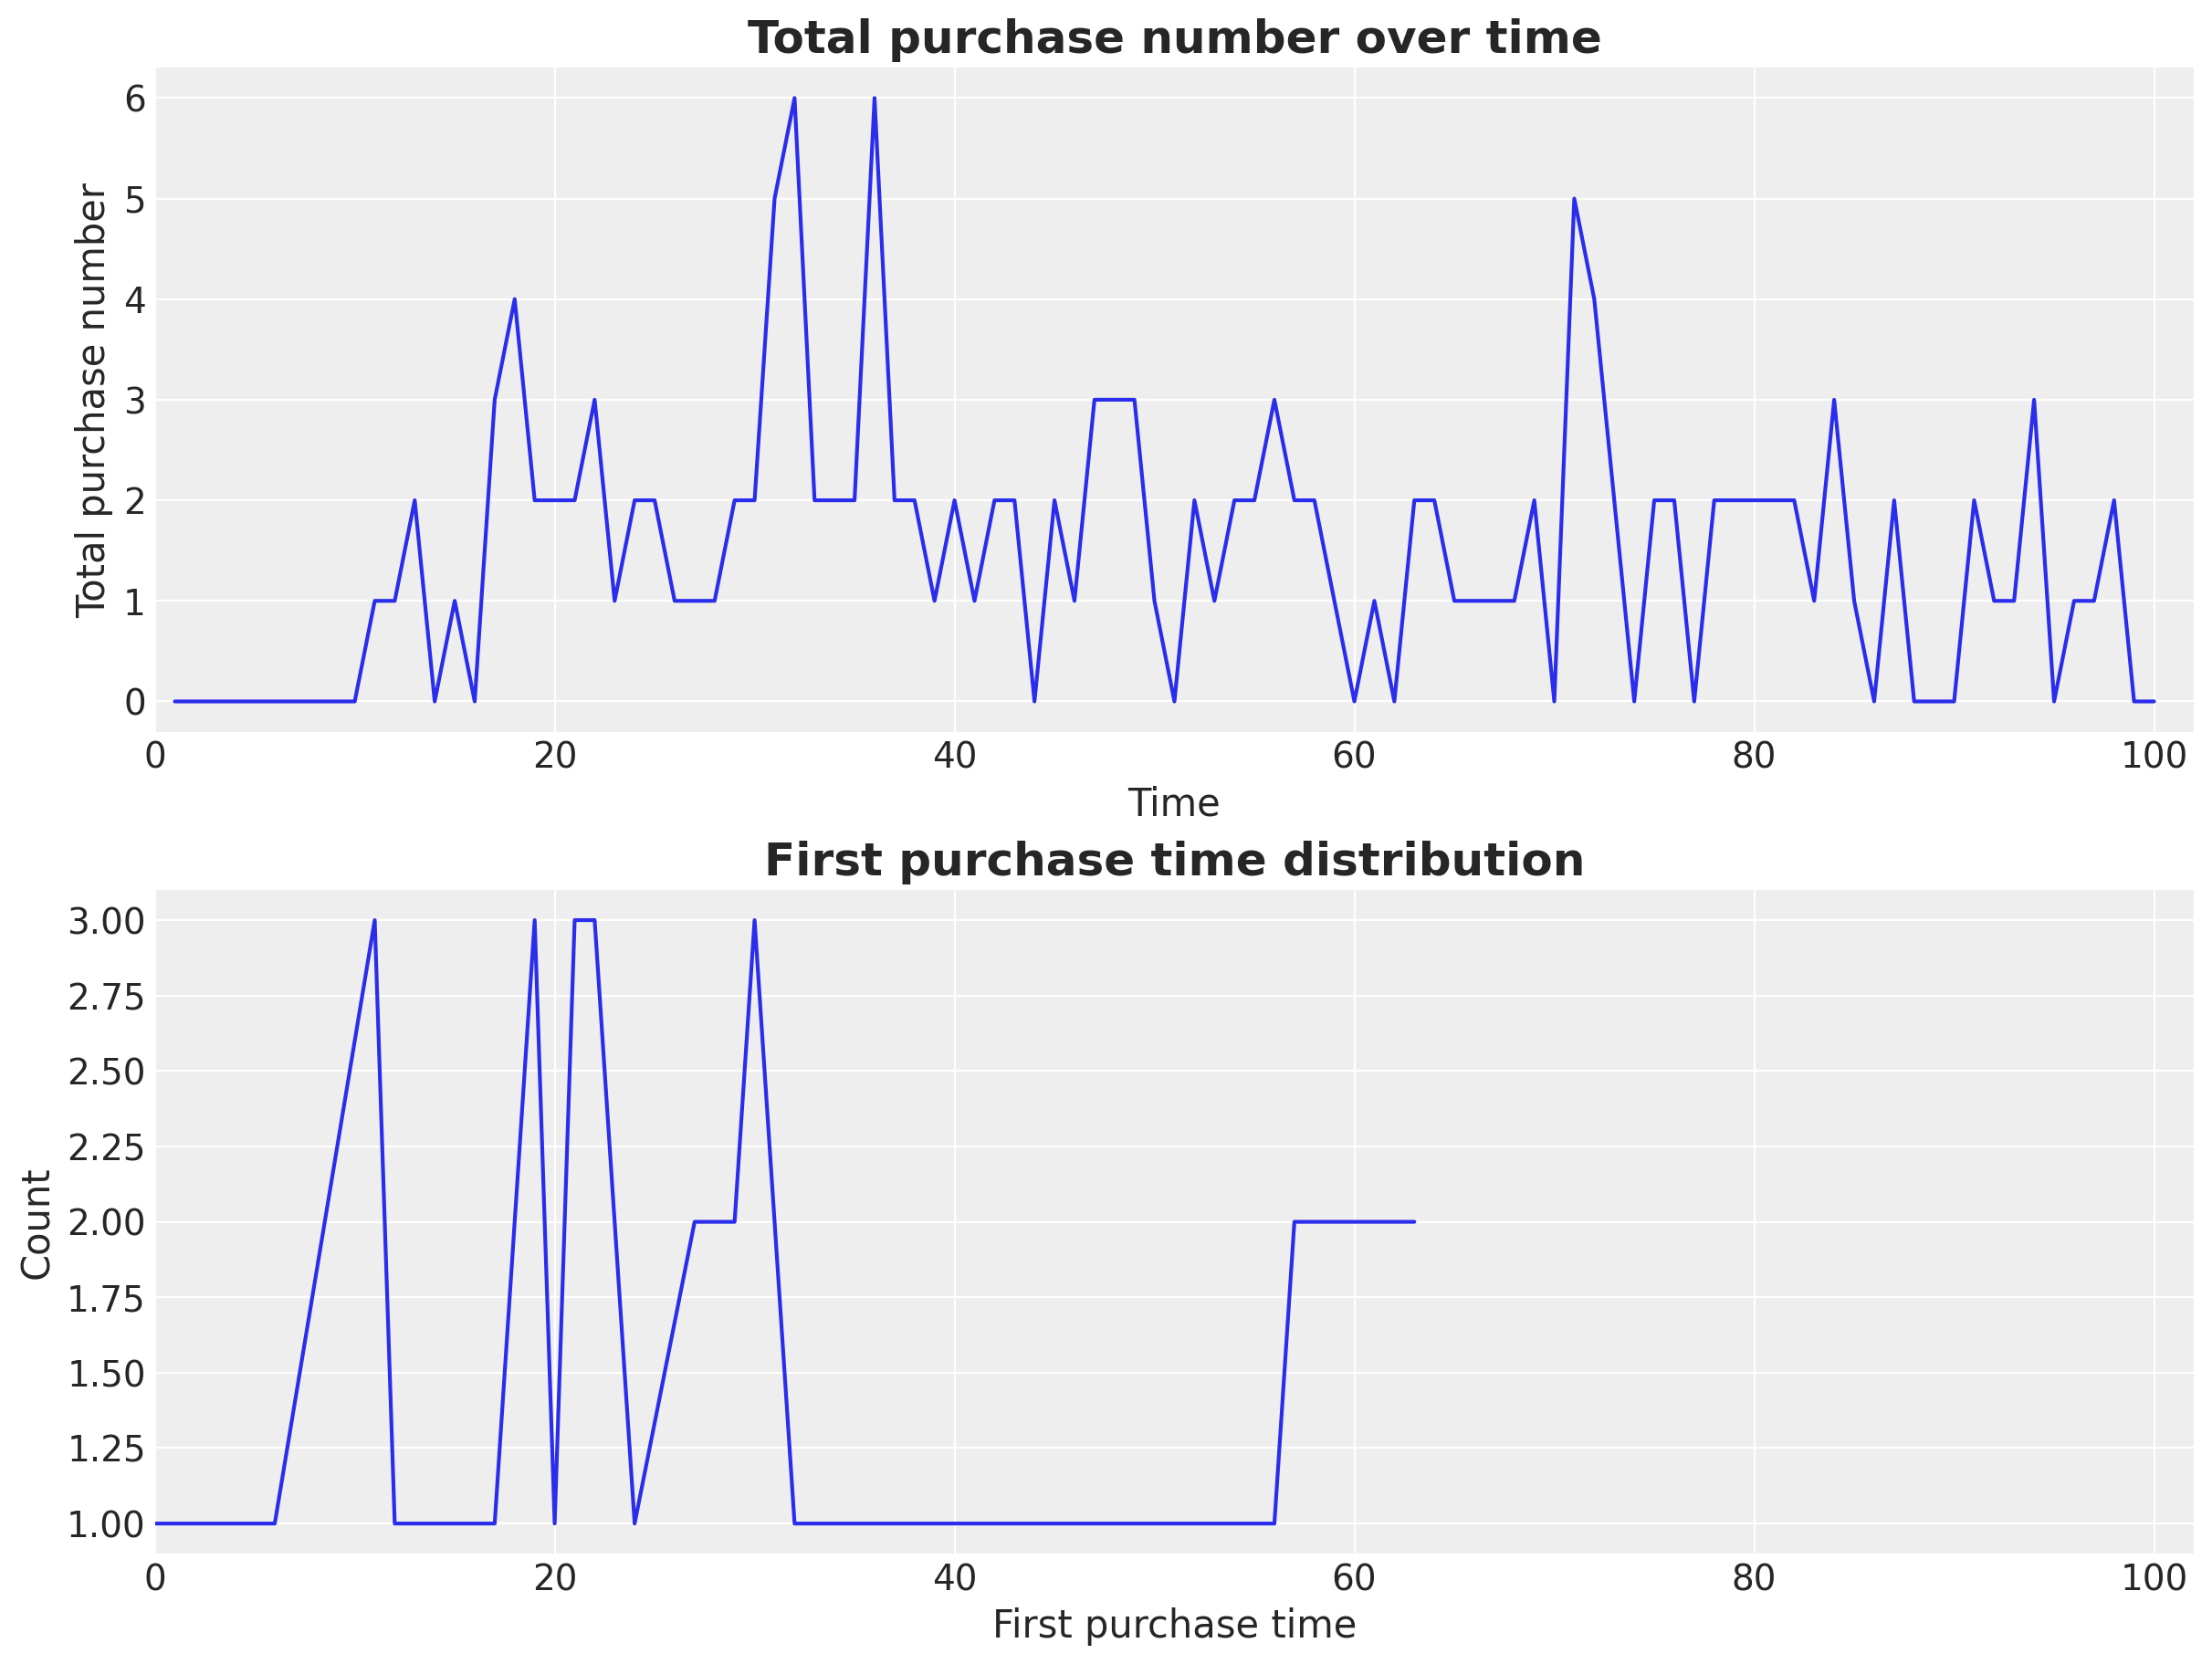

In [8]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

data_df.group_by("t").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(data=df, x="t", y="total_y", ax=ax[0])
)
ax[0].set(xlabel="Time", ylabel="Total purchase number", xlim=(0, 102))
ax[0].set_title("Total purchase number over time", fontsize=18, fontweight="bold")

data_df.select(pl.col("id"), pl.col("fs")).unique(subset=["id", "fs"]).group_by(
    "fs"
).len().pipe(lambda df: sns.lineplot(data=df, x="fs", y="len", ax=ax[1]))
ax[1].set(xlabel="First purchase time", ylabel="Count", xlim=(0, 102))
ax[1].set_title("First purchase time distribution", fontsize=18, fontweight="bold");

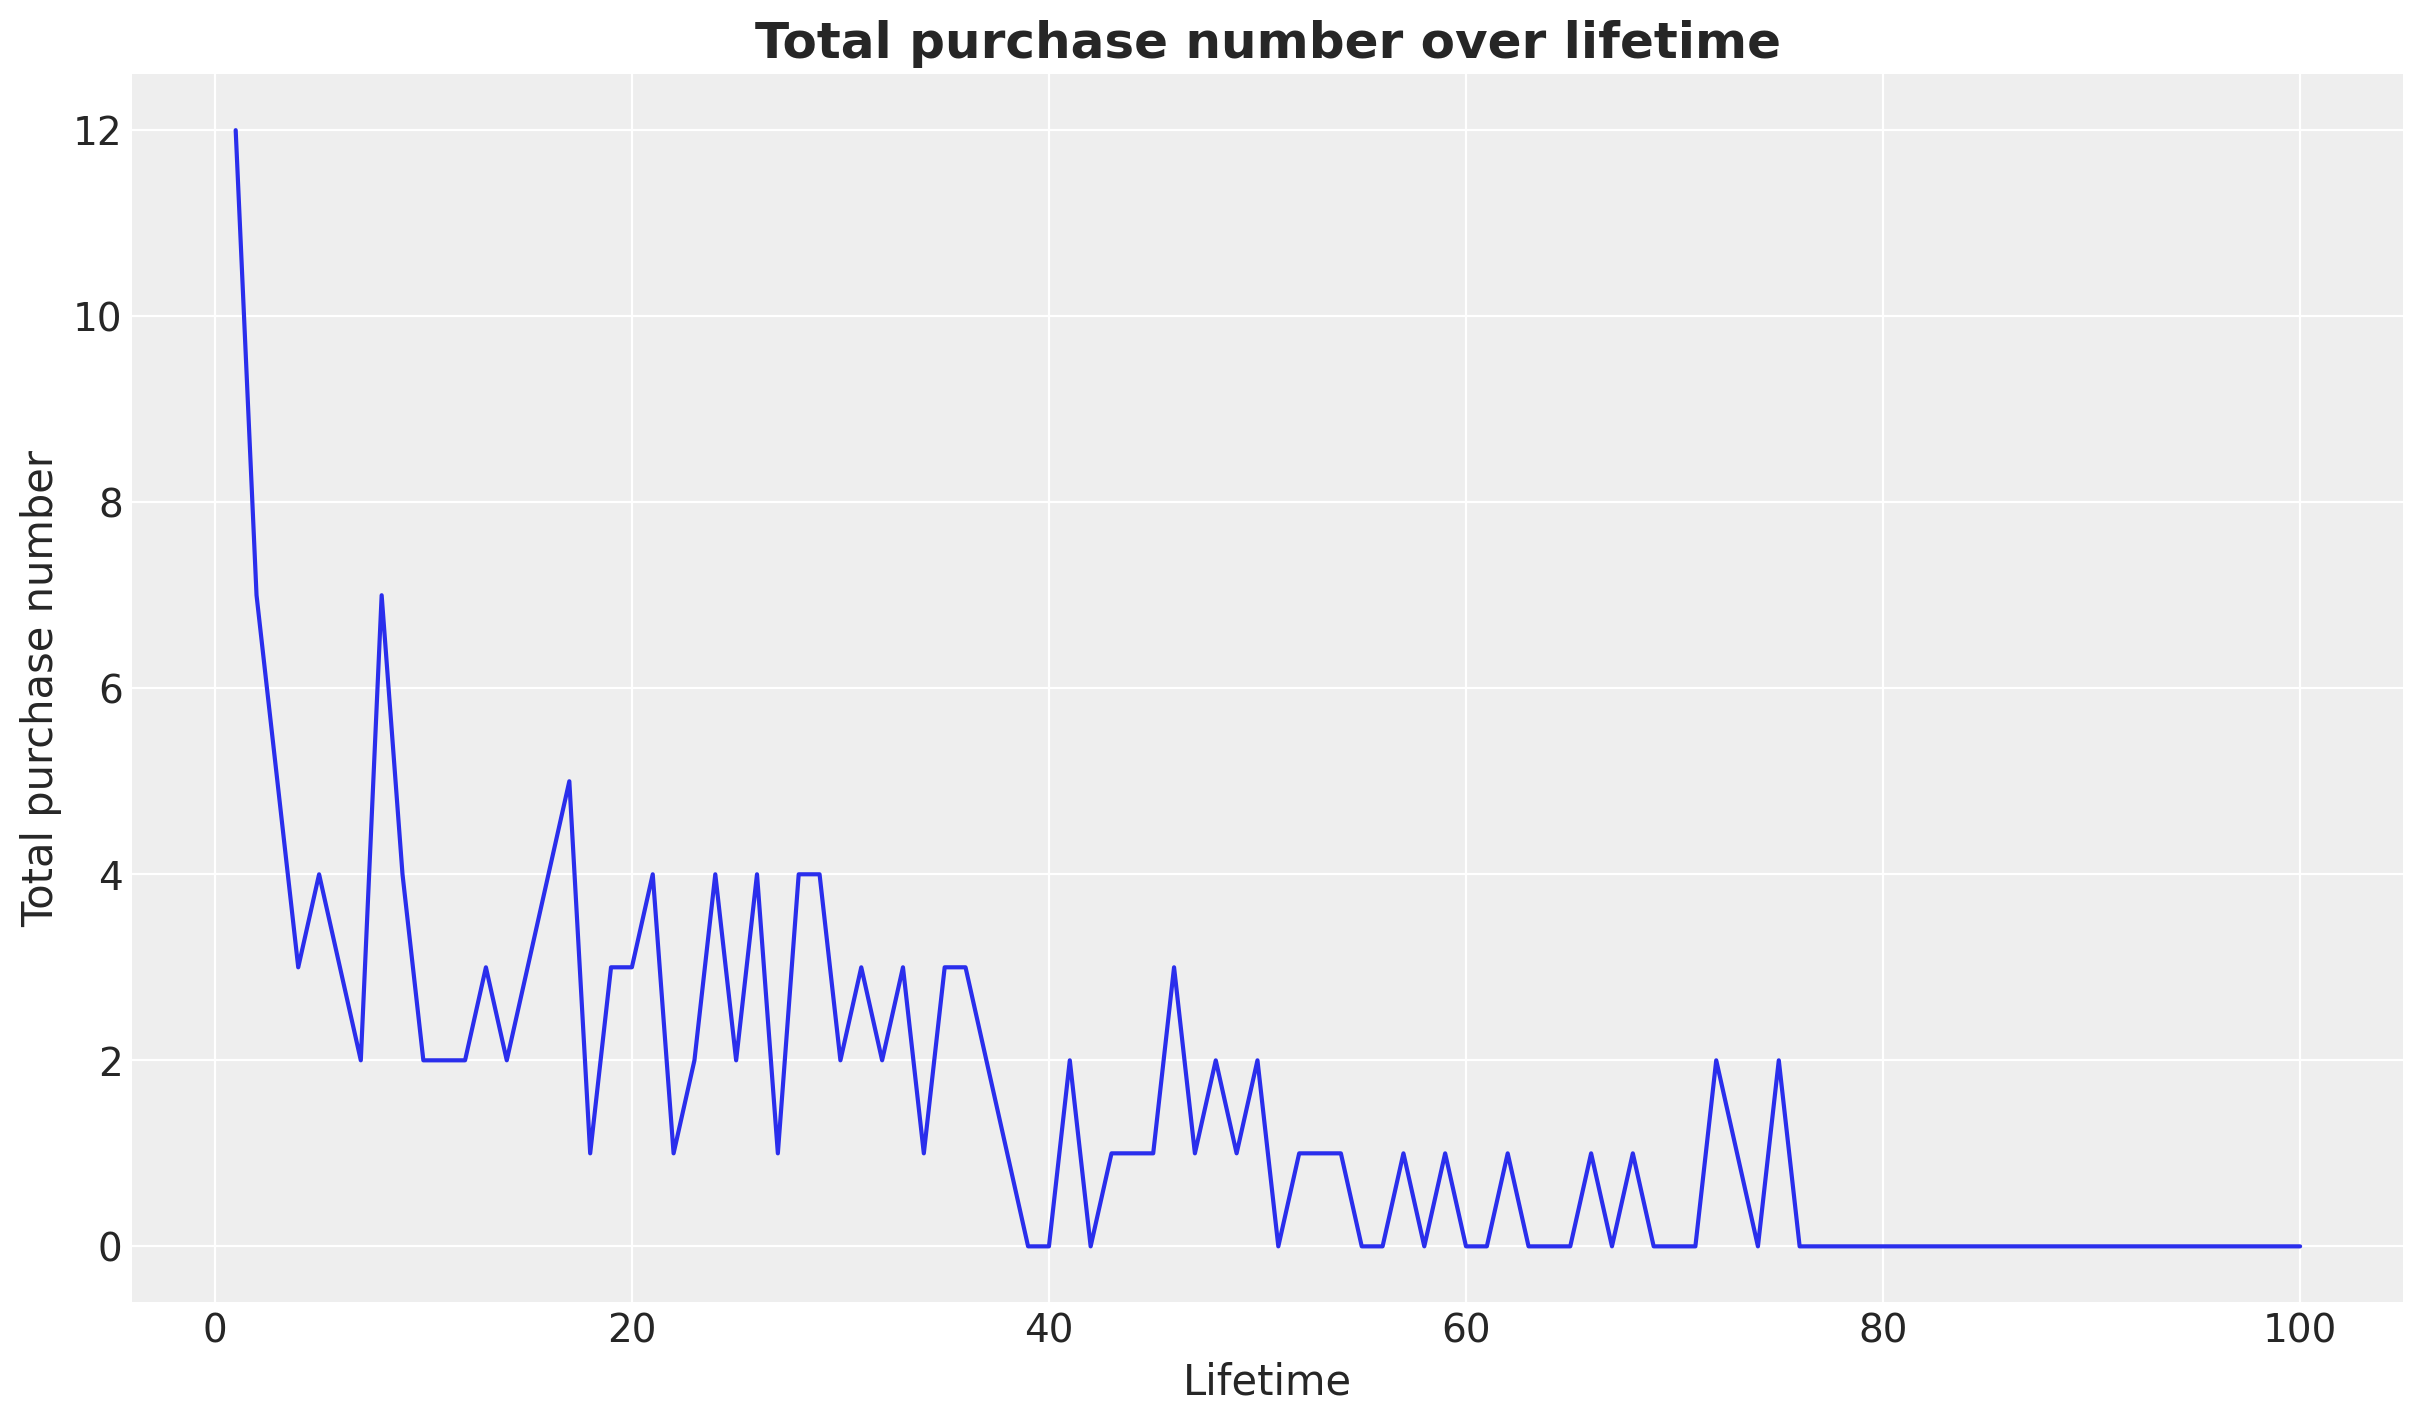

In [9]:
fig, ax = plt.subplots()
data_df.group_by("l").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(data=df, x="l", y="total_y", ax=ax)
)
ax.set(xlabel="Lifetime", ylabel="Total purchase number")
ax.set_title("Total purchase number over lifetime", fontsize=18, fontweight="bold");

## Train Test Split

In [10]:
data_df["fs"].max()

63

In [11]:
fs_threshold = data_df["fs"].max() + 1

data_df = data_df.with_columns(
    idx_id=pl.col("id").rank("dense") - 1,
    idx_t=pl.col("t").rank("dense") - 1,
)

train_df = data_df.filter(pl.col("t") <= fs_threshold)
test_df = data_df.filter(pl.col("t") > fs_threshold)

In [12]:
assert set(train_df["id"].unique()) == set(test_df["id"].unique())

In [13]:
# Train data
n_train = train_df.shape[0]
id_train = jnp.array(train_df["id"].unique())
idx_id_train = jnp.array(train_df["idx_id"])
t_train = jnp.array(train_df["t"].sort().unique())
idx_t_train = jnp.array(train_df["idx_t"])
rec_train = jnp.array(train_df["r"])
life_train = jnp.array(train_df["l"])
pnum_train = jnp.array(train_df["pnum"] - train_df["pnum"].min() + 1)
y_train = jnp.array(train_df["y"])

# Test data
n_test = jnp.array(test_df.shape[0])
id_test = jnp.array(test_df["id"])
idx_id_test = jnp.array(test_df["idx_id"])
t_test = jnp.array(test_df["t"].sort().unique())
idx_t_test = jnp.array(test_df["idx_t"] - fs_threshold)
rec_test = jnp.array(test_df["r"])
life_test = jnp.array(test_df["l"])
pnum_test = jnp.array(test_df["pnum"] - train_df["pnum"].min() + 1)
y_test = jnp.array(test_df["y"])

In [14]:
assert t_train.min() == 1
assert t_test.min() == fs_threshold + 1
np.testing.assert_equal(t_train[idx_t_train], train_df["t"].to_numpy())
np.testing.assert_equal(t_test[idx_t_test], test_df["t"].to_numpy())

assert pnum_train.min() == 1
assert pnum_test.min() == 1

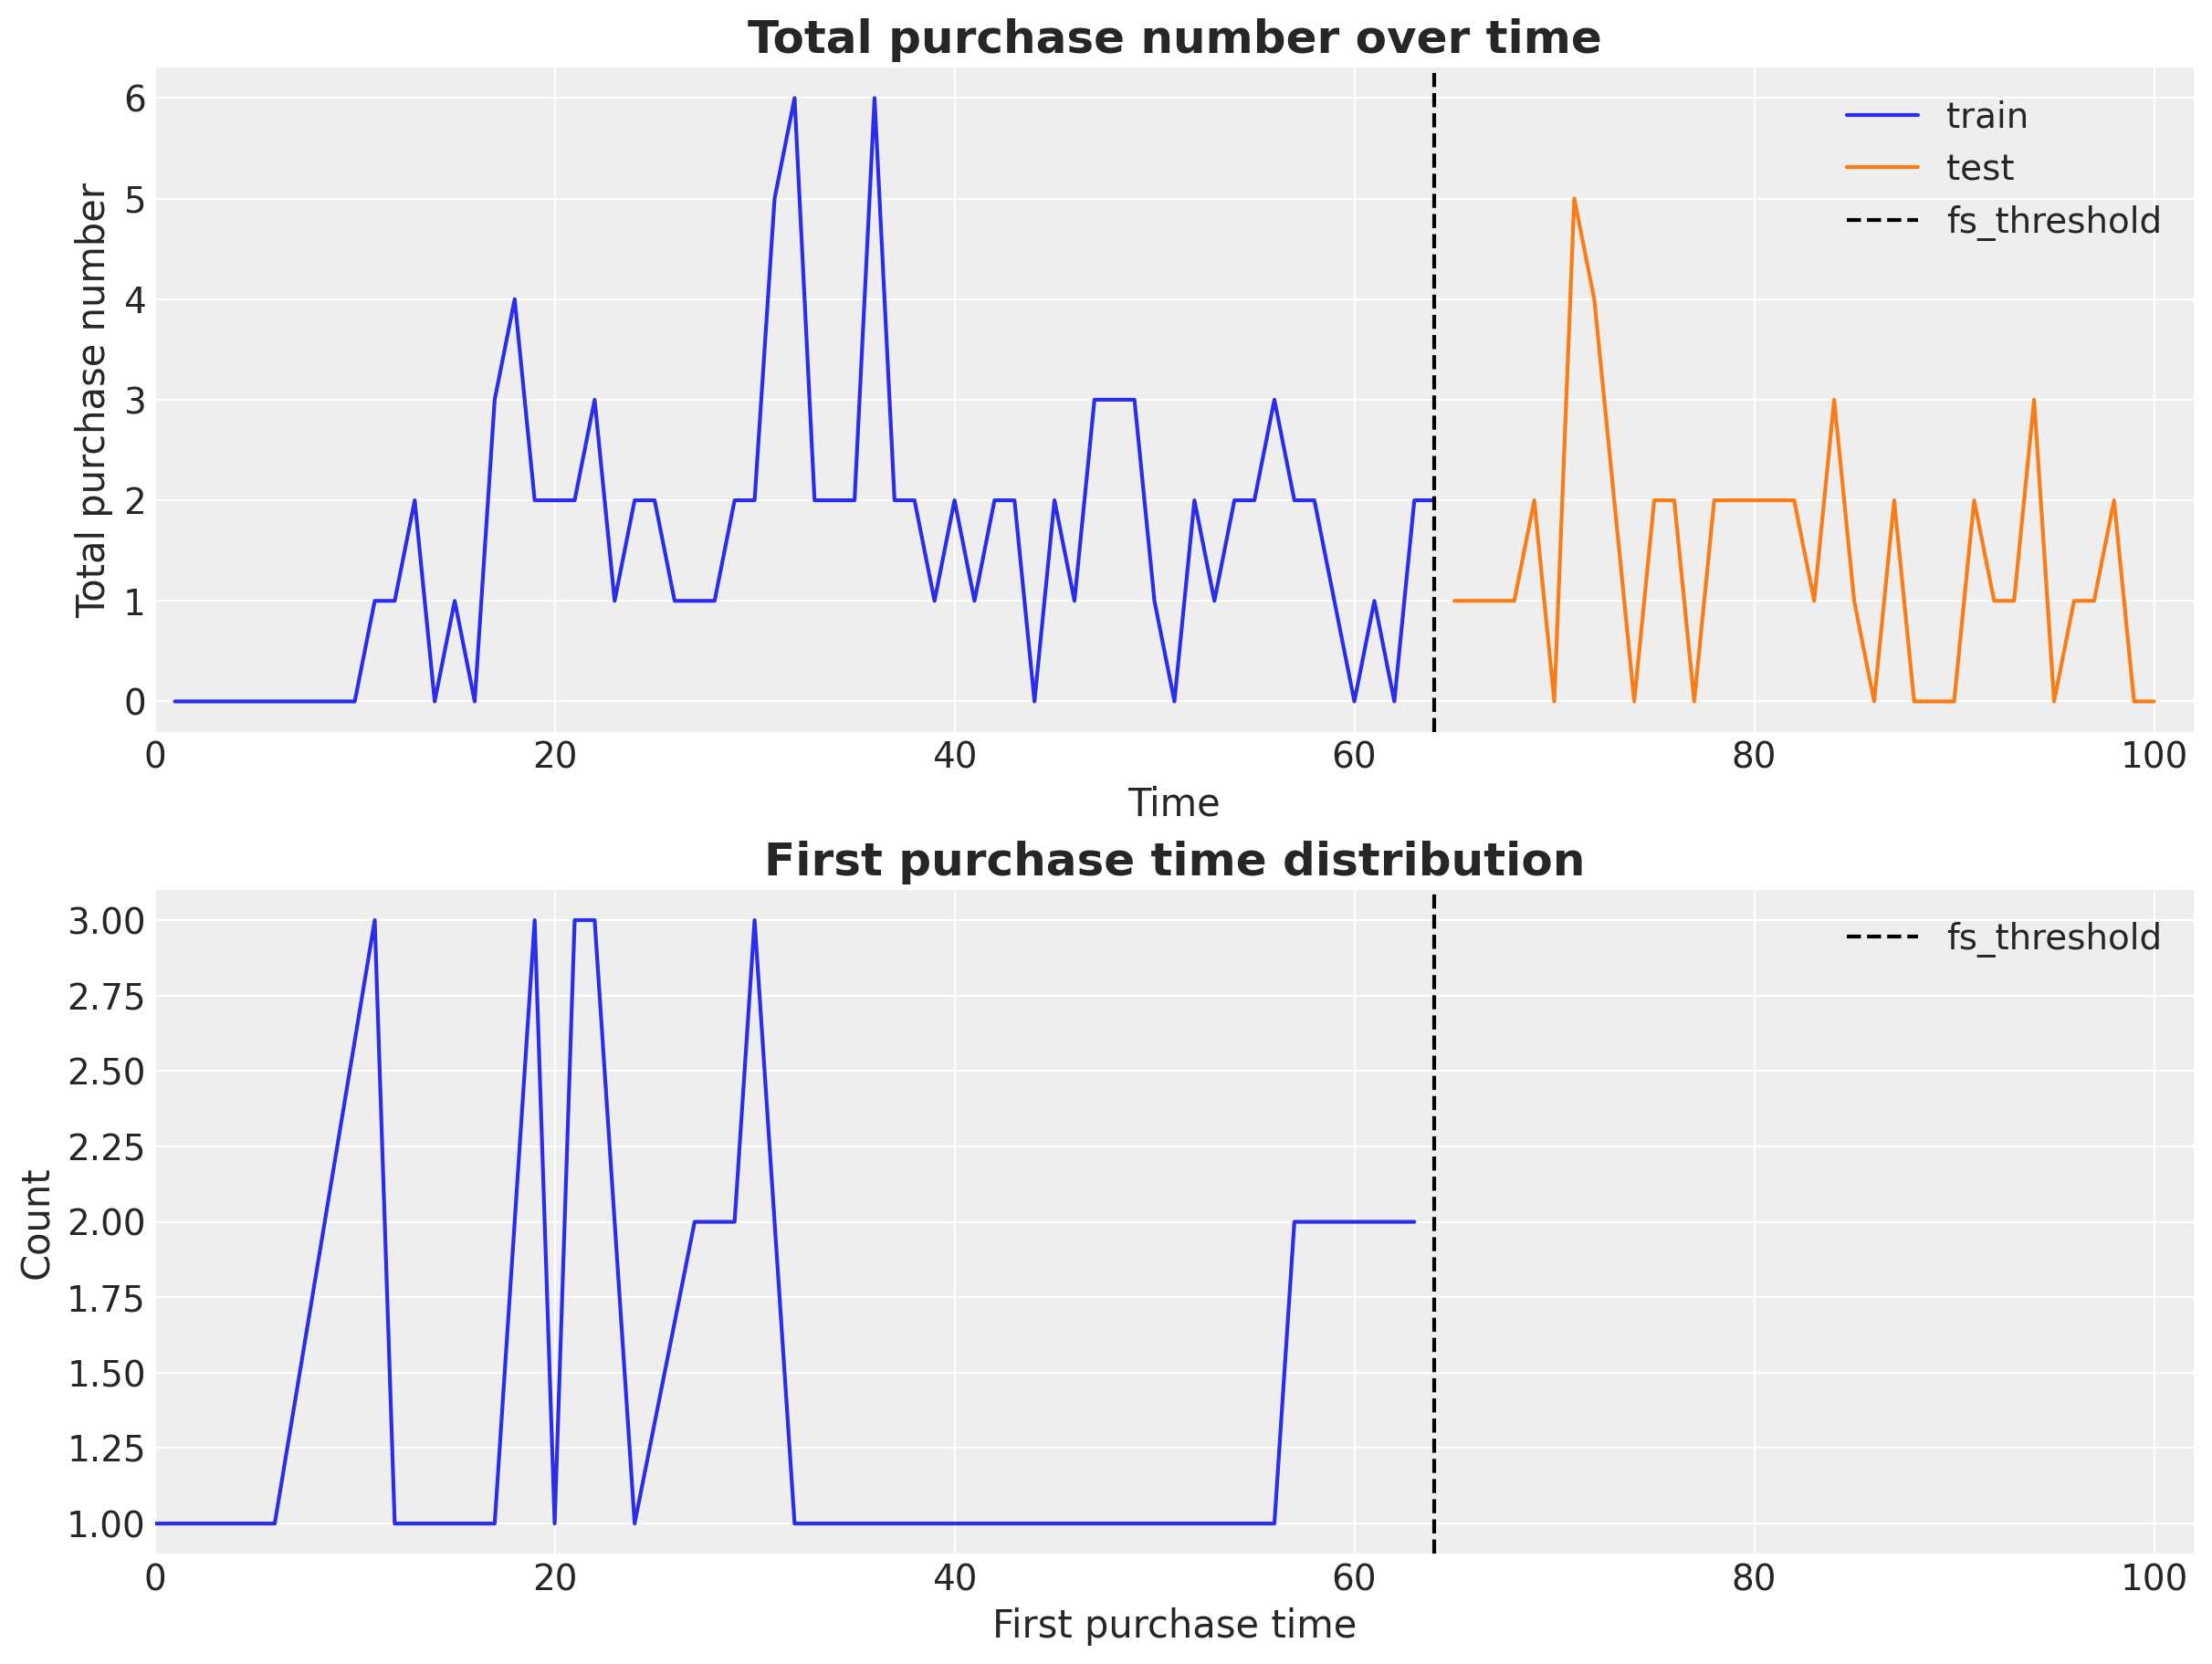

In [15]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

train_df.group_by("t").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(
        data=df, x="t", y="total_y", color="C0", label="train", ax=ax[0]
    )
)
test_df.group_by("t").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(
        data=df, x="t", y="total_y", color="C1", label="test", ax=ax[0]
    )
)
ax[0].axvline(fs_threshold, color="black", linestyle="--", label="fs_threshold")
ax[0].legend(loc="upper right")
ax[0].set(xlabel="Time", ylabel="Total purchase number", xlim=(0, 102))
ax[0].set_title("Total purchase number over time", fontsize=18, fontweight="bold")

train_df.select(pl.col("id"), pl.col("fs")).unique(subset=["id", "fs"]).group_by(
    "fs"
).len().pipe(lambda df: sns.lineplot(data=df, x="fs", y="len", color="C0", ax=ax[1]))
ax[1].axvline(fs_threshold, color="black", linestyle="--", label="fs_threshold")
ax[1].legend(loc="upper right")
ax[1].set(xlabel="First purchase time", ylabel="Count", xlim=(0, 102))
ax[1].set_title("First purchase time distribution", fontsize=18, fontweight="bold");

## Model

In [16]:
def alpha_week_gp(x, t_max, period, m):
    alpha = numpyro.sample("alpha", dist.HalfNormal(scale=5.0))
    length = numpyro.sample(
        "length", dist.LogNormal(loc=jnp.log(t_max / 2), scale=t_max)
    )
    return approx_periodic_gp_ncp(
        x=x, alpha=alpha, length=length, w0=(jnp.pi * 2 / period), m=m
    )


def alpha_long_gp(x, t_max, ell, m):
    alpha = numpyro.sample("alpha", dist.HalfNormal(scale=5.0))
    length = numpyro.sample(
        "length", dist.LogNormal(loc=jnp.log(t_max / 2), scale=t_max)
    )
    return approx_se_ncp(x=x, alpha=alpha, length=length, ell=ell, m=m)


def alpha_short_gp(x, t_max, ell, m):
    alpha = numpyro.sample("alpha", dist.HalfNormal(scale=5.0))
    length = numpyro.sample(
        "length", dist.LogNormal(loc=jnp.log(t_max / 10), scale=t_max / 5)
    )
    return approx_se_ncp(x=x, alpha=alpha, length=length, ell=ell, m=m)


def model(t, idx_t, ell_t, period, m_week, m_long, m_short, y=None):
    obs = idx_t.size
    t_max = t.max()

    f_alpha_week = scope(alpha_week_gp, prefix="alpha_week_gp", divider="::")(
        x=t,
        t_max=t_max,
        period=period,
        m=m_week,
    )

    f_alpha_long = scope(alpha_long_gp, prefix="alpha_long_gp", divider="::")(
        x=t, t_max=t_max, ell=ell_t, m=m_long
    )

    f_alpha_short = scope(alpha_short_gp, prefix="alpha_short_gp", divider="::")(
        x=t, t_max=t_max, ell=ell_t, m=m_short
    )

    logit_p = f_alpha_week[idx_t] + f_alpha_long[idx_t] + f_alpha_short[idx_t]
    p = numpyro.deterministic("p", expit(logit_p))

    with numpyro.plate("data", obs):
        numpyro.sample("obs", dist.Bernoulli(p), obs=y)

## Inference

In [17]:
sampler = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(sampler, num_warmup=1_000, num_samples=2_000, num_chains=4)
rng_key, rng_subkey = random.split(key=rng_key)
mcmc.run(
    rng_subkey,
    t=t_train,
    idx_t=idx_t_train,
    ell_t=120,
    period=7,
    m_week=10,
    m_long=20,
    m_short=20,
    y=y_train,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [18]:
idata = az.from_numpyro(
    posterior=mcmc,
    coords={"t": t_train, "obs": range(n_train)},
    dims={"p": ["obs"], "alpha_long_gp::f": ["t"], "alpha_week_gp::f": ["t"]},
)

In [19]:
idata.sample_stats.diverging.sum().item()

7055

<Axes: >

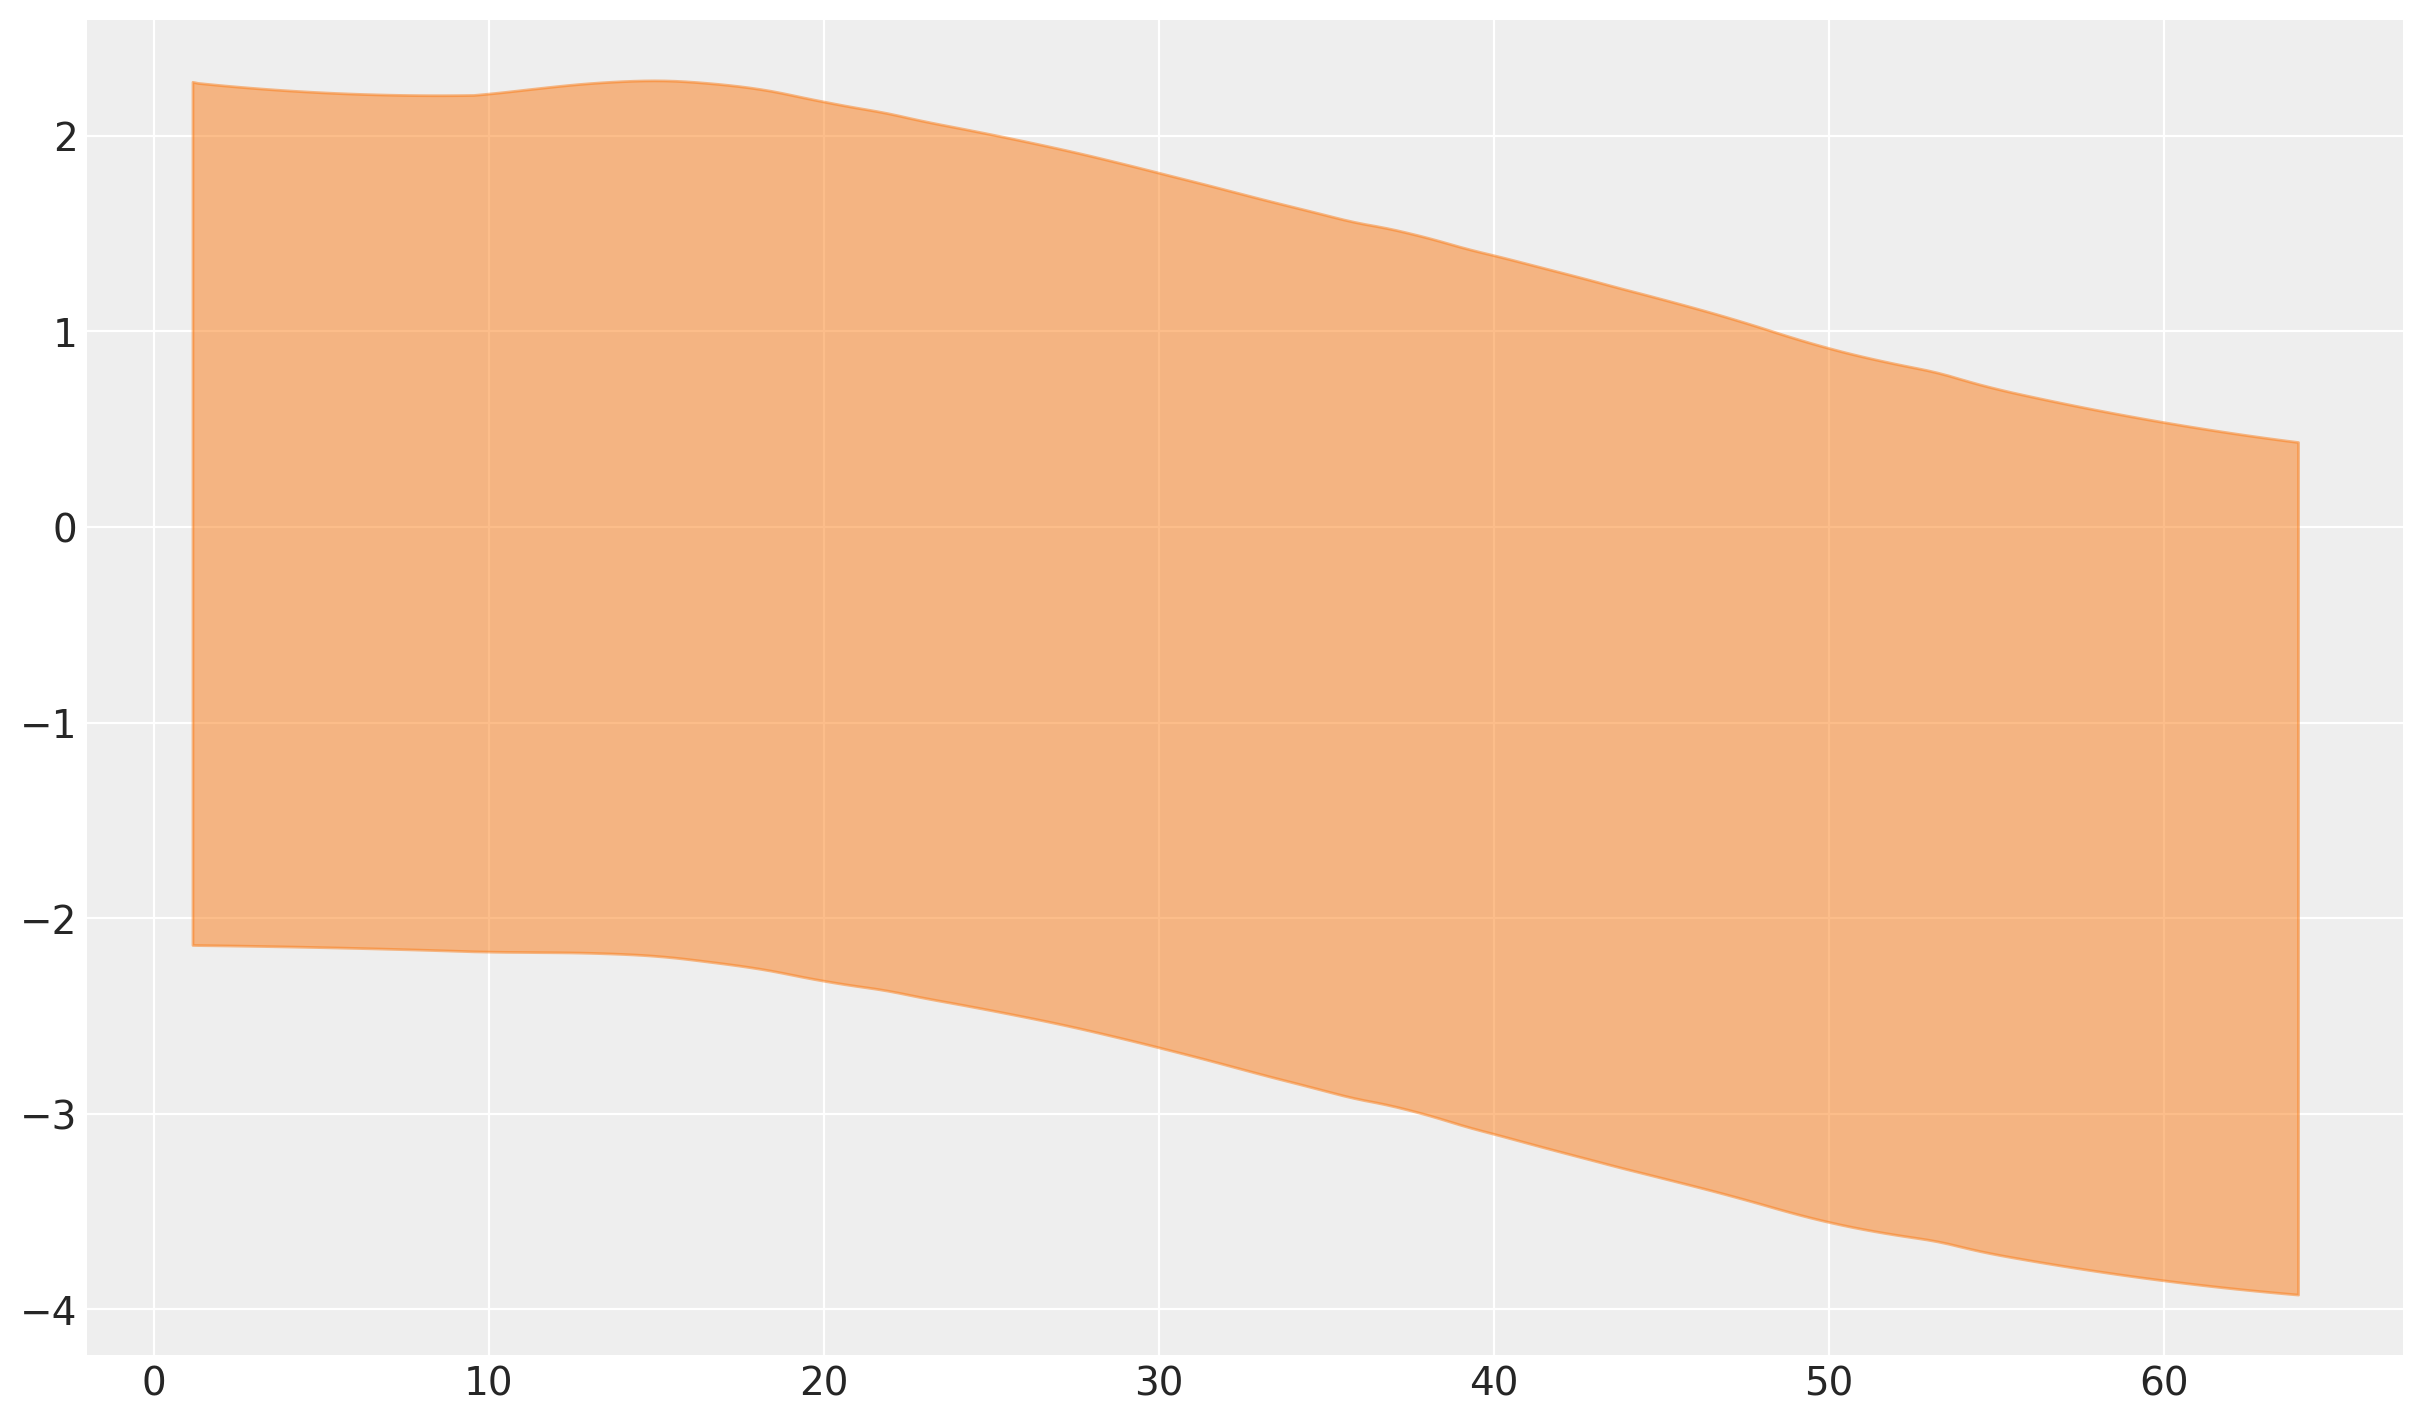

In [22]:
az.plot_hdi(t_train, idata.posterior["alpha_long_gp::f"])

<Axes: >

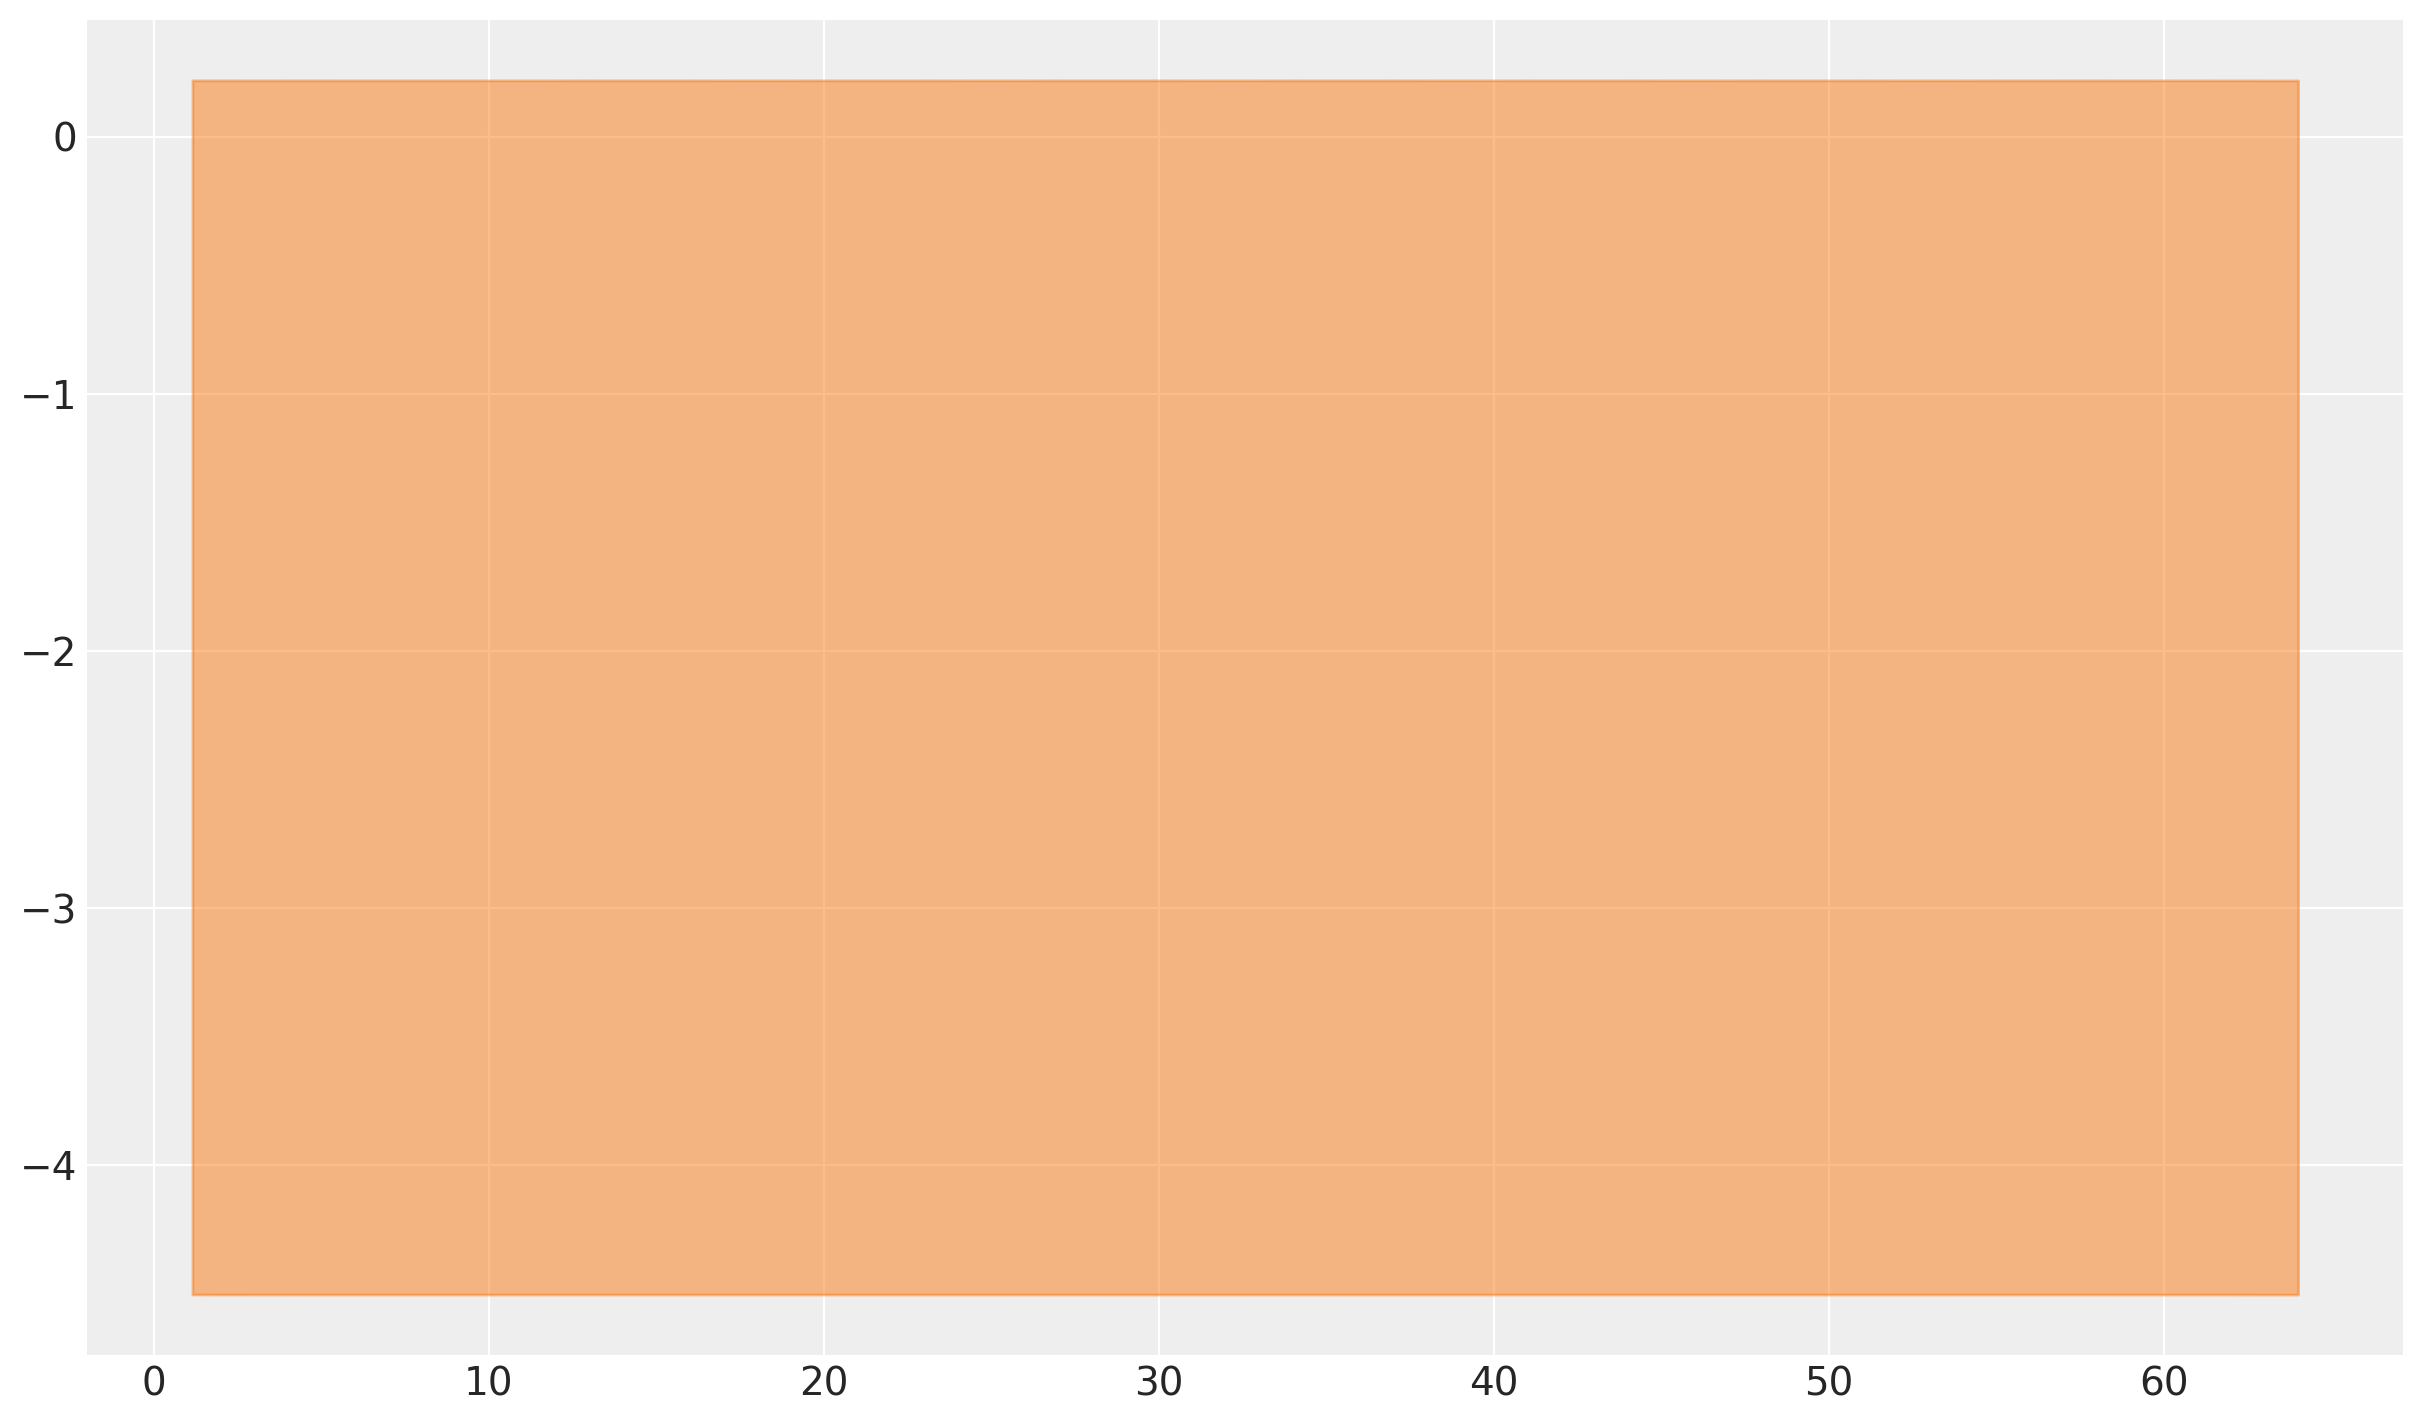

In [21]:
az.plot_hdi(t_train, idata.posterior["alpha_week_gp::f"])